In [10]:
# Reading data and plot it.
import pandas as pd
import matplotlib.pyplot as plt

# Stream learning
from river import compose, preprocessing, linear_model, tree, metrics, evaluate, feature_extraction, utils, stats

# Batch learning 
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# Load dataset

In [ ]:
# Read api request from a csv
df = pd.read_csv("datasets/data.csv")
df["dt"] = pd.to_datetime(df["dt"], unit='s')

# We are going to predict if temperature increases or decreases in the next six hours.
# Therefore, we create our target variable
# Maybe smooth it a little before
df["temp_diff_6h"] = df["main.temp"].diff(periods=6)
df["target"] = (df["temp_diff_6h"] > 0).astype(int)
df.drop(["temp_diff_6h"], axis = 1)

,Unnamed: 0,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,weather.main,weather.description,weather.icon,rain.1h,temp_diff_6h,target
0,0,2024-02-22 16:00:00,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,Clouds,broken clouds,04d,NaN,NaN,0
1,1,2024-02-22 17:00:00,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,Clouds,broken clouds,04d,NaN,NaN,0
2,2,2024-02-22 18:00:00,9.04,6.77,1010,84,8.03,10.44,4.12,260,NaN,75,803,Clouds,broken clouds,04d,NaN,NaN,0
3,3,2024-02-22 19:00:00,8.74,6.66,1010,82,7.50,10.50,3.60,250,NaN,75,300,Drizzle,light intensity drizzle,09n,NaN,NaN,0
4,4,2024-02-22 20:00:00,8.17,5.24,1010,84,6.92,9.38,5.14,250,NaN,75,300,Drizzle,light intensity drizzle,09n,NaN,NaN,0


# Analisis descriptivo

In [24]:
df.head(2)

,Unnamed: 0,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,weather.main,weather.description,weather.icon,rain.1h,temp_diff_6h,target,month
0,0,2024-02-22 16:00:00,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,Clouds,broken clouds,04d,NaN,NaN,0,2
1,1,2024-02-22 17:00:00,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,Clouds,broken clouds,04d,NaN,NaN,0,2


In [ ]:
# Tenemos 8K datos, hay que eliminar las variables con nulos porque son muchisimos
null_counts = df.isnull().sum()
print(null_counts)

Unnamed: 0                0
dt                        0
main.temp                 0
main.feels_like           0
main.pressure             0
main.humidity             0
main.temp_min             0
main.temp_max             0
wind.speed                0
wind.deg                  0
wind.gust              6826
clouds.all                0
weather.id                0
weather.main              0
weather.description       0
weather.icon              0
rain.1h                7705
temp_diff_6h              6
target                    0
month                     0
dtype: int64


C:\Users\Alogon\AppData\Local\Temp\ipykernel_25060\663171325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette="Blues_d")


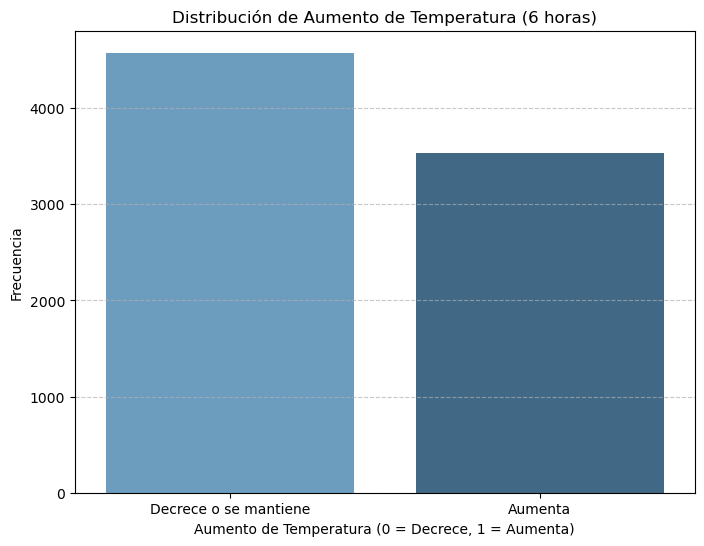

In [22]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x="target", data=df, palette="Blues_d")

# Labeling the plot
plt.xlabel("Aumento de Temperatura (0 = Decrece, 1 = Aumenta)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Aumento de Temperatura (6 horas)")
plt.xticks(ticks=[0, 1], labels=['Decrece o se mantiene', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

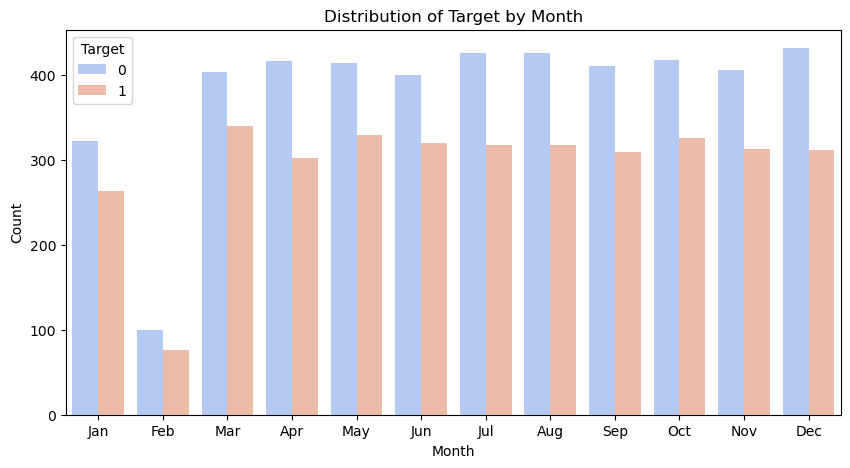

In [ ]:
# Distribucion de las clases por mes para ver si al cortar por algun mes nos quedaban las 
# clases imbalanceadas en test.
import seaborn as sns
df["month"] = df["dt"].dt.month
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="month", hue="target", palette="coolwarm")

# Labels and title
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Distribution of Target by Month")
plt.xticks(ticks=range(12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.legend(title="Target", labels=["0", "1"])
plt.show()

# Particion train-test (debe ser igual en batch y stream learning)

In [7]:
train_df = df[df["month"] <= 8] 
test_df = df[df["month"] > 8]    

# Pipeline

In [ ]:
# Pipeline final en river
# Pendiente: wrapper para que se pueda usar en sklearn.
cols_rolling = ["main.temp", "main.feels_like", "main.pressure", "main.humidity",
                 "main.temp_max", "main.temp_min", "wind.speed", "wind.debug"]
to_discard = ['store_id', 'date', 'genre_name', 'area_name', 'latitude', 'longitude']
def get_date_features(x):
    month =  x['dt'].month()
    return {'month': month, 
            'is_winter': month in (1,2,3), 'is_spring': month in (4,5,6),
            'is_summer': month in (7,8,9), 'is_autumn': month in (10,11,12)}

model = get_date_features

for col in cols_rolling:
    model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 6))

model |= compose.Discard(*to_discard)
model |= preprocessing.StandardScaler()
model |= linear_model.LogisticRegression()

# Funciones de utilidad (pendiente de adaptarlas al problema)

In [ ]:
# Pendiente ver:
    # - Que metrica usa, por ahora está accuracy.
    # - Cambiar para que itere usando stream.iter_pandas
    # - Poner el drift accuracy sobre el accuracy del modelo en vez de una columna de X (x[0]) está ahora
    # - Ver que la función dual accuracy funciona bien.

def stream_learning(X, y, modelo, drift_detect):
    # Inicializamos los detectores 
    drift_detector = drift_detect()

    # Almacenamos los indices donde hay cambios
    drifts = []

    # Almacenamos los valores de accuracy segun vayan llegando datos.
    acc_values = []

    model = modelo

    acc2 = metrics.Accuracy()
    report2 = metrics.ClassificationReport()
    counter = 0

    for i, (x_dict, y) in enumerate(dataset):
        x = list(x_dict.values())

        if drift_detector.drift_detected:
            print(f'Change detected at index {i}')
            # Guardar el indice donde se detecta un cambio.
            if drift_detector.drift_detected:
                drifts.append(i)

            # Reiniciar el modelo cuando se detecta un cambio
            model = compose.Pipeline(preprocessing.StandardScaler(), modelo())

        y_pred = model.predict_one(x_dict)
        model = model.learn_one(x_dict, y)
        
        if y_pred != None:
            report2.update(y, y_pred)
            acc2.update(y, y_pred)
            drift_detector.update(x[0])

        if counter % 25 == 0:
            print(f'{acc2}')
            acc_values.append(acc2.get())
        counter += 1

    return acc_values, drifts, report2

train_df = df[df["month"] <= 8] 
test_df = df[df["month"] > 8]  

X_train = train_df
y_train = X_train.pop('target')
X_test = test_df
y_test = X_test.pop('target')

In [ ]:
# Hay que usar esto en las funciones para iterar
from river import stream
cnt = 0
for xi, yi in stream.iter_pandas(X_train, y_train):
    print(xi, yi)
    cnt += 1
    if cnt == 2:
        break

{'Unnamed: 0': 0, 'dt': Timestamp('2024-02-22 16:00:00'), 'main.temp': 10.79, 'main.feels_like': 9.83, 'main.pressure': 1010, 'main.humidity': 73, 'main.temp_min': 9.14, 'main.temp_max': 11.61, 'wind.speed': 7.72, 'wind.deg': 290, 'wind.gust': 14.92, 'clouds.all': 75, 'weather.id': 803, 'weather.main': 'Clouds', 'weather.description': 'broken clouds', 'weather.icon': '04d', 'rain.1h': nan, 'temp_diff_6h': nan, 'month': 2} 0
{'Unnamed: 0': 1, 'dt': Timestamp('2024-02-22 17:00:00'), 'main.temp': 9.69, 'main.feels_like': 7.35, 'main.pressure': 1010, 'main.humidity': 81, 'main.temp_min': 8.58, 'main.temp_max': 11.4, 'wind.speed': 4.63, 'wind.deg': 290, 'wind.gust': nan, 'clouds.all': 75, 'weather.id': 803, 'weather.main': 'Clouds', 'weather.description': 'broken clouds', 'weather.icon': '04d', 'rain.1h': nan, 'temp_diff_6h': nan, 'month': 2} 0


In [ ]:
import numpy as np
# Con esta funcion ploteamos los resultados de stream_learning()

# Muestra el resultado de dos modelos, hay que adaptarla para que saque 3.
def plot_accuracy_dual(acc_values_1, acc_values_2, drifts):
    """
    Dibuja la precisión del modelo con y sin detector segun van obteniendo más datos,
    permitiendo visualizar el efecto del detector.

    Parámetros:
    - acc_values_1: Lista con los valores de precisión para el modelo incremental sin detector.
    - acc_values_2: Lista con los valores de precisión para el modelo incremental con detector.
    - drifts: Lista con los indices donde se produjeron cambios de la distribución de x1.

    """
    indices = np.arange(min(len(acc_values_1), len(acc_values_2)))

    indices = indices*25

    plt.plot(indices, acc_values_1, label='Accuracy sin detector', color='blue')
    plt.plot(indices, acc_values_2, label='Accuracy con detector', color='orange')
    for value in drifts:
        plt.axvline(x=value, color='red', linestyle='--', label='Drift 1')

    custom_legend = [
        plt.Line2D([0], [0], color='blue', label='Accuracy sin detector'),
        plt.Line2D([0], [0], color='orange', label='Accuracy con detector'),
        plt.Line2D([0], [0], color='red', linestyle='--', label='Drift 1 (rojo)'),
        plt.Line2D([0], [0], color='green', linestyle='--', label='Drift 2 (verde)')
    ]

    plt.legend(handles=custom_legend)
    plt.xlabel('Índices')
    plt.ylabel('Precisión')
    plt.title('Precisión a lo largo del tiempo')
    plt.show()

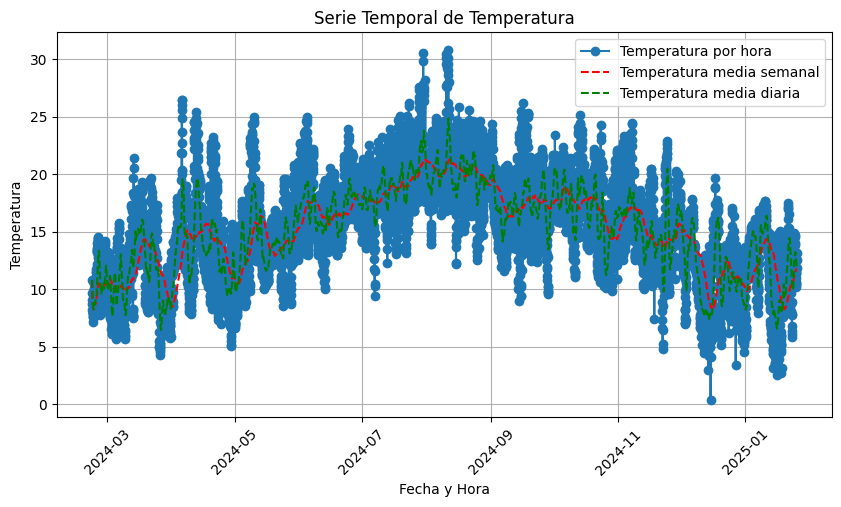

In [ ]:
# df = pd.read_csv("data.csv")
# df["dt"] = pd.to_datetime(df["dt"], unit='s')

# # Suavizar la serie temporal usando una media móvil
# window_size = 24*7
# df["smoothed_temp_week"] = df["main.temp"].rolling(window=window_size, min_periods=1).mean()
# window_size = 24
# df["smoothed_temp_day"] = df["main.temp"].rolling(window=window_size, min_periods=1).mean()

# # Graficar la serie temporal de temperatura
# plt.figure(figsize=(10, 5))
# plt.plot(df["dt"], df["main.temp"], marker='o', linestyle='-', label='Temperatura por hora')
# plt.plot(df["dt"], df["smoothed_temp_week"], color='red', linestyle='--', label='Temperatura media semanal')
# plt.plot(df["dt"], df["smoothed_temp_day"], color='green', linestyle='--', label='Temperatura media diaria')
# plt.xlabel("Fecha y Hora")
# plt.ylabel("Temperatura")
# plt.title("Serie Temporal de Temperatura")
# plt.grid()
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

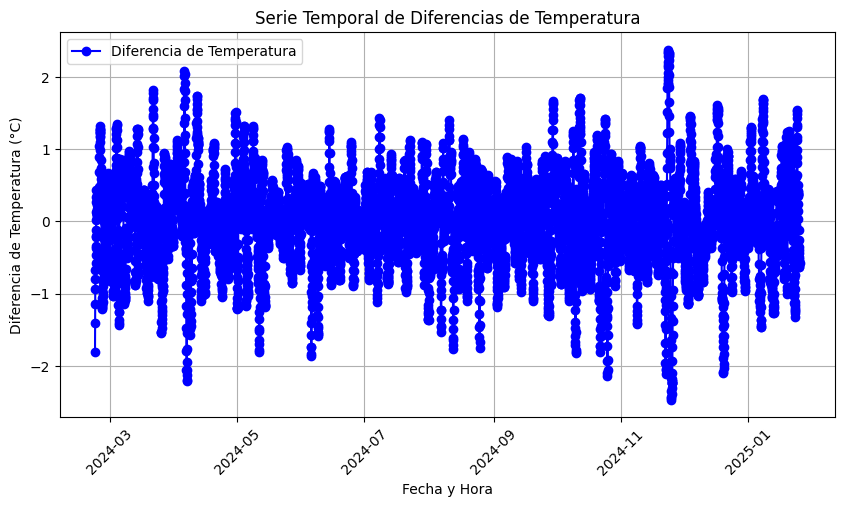

In [ ]:
# df["temp_diff"] = df["smoothed_temp_day"].diff(periods=6)

# # Graficar la serie temporal de diferencias de temperatura
# plt.figure(figsize=(10, 5))
# plt.plot(df["dt"], df["temp_diff"], marker='o', linestyle='-', color='blue', label='Diferencia de Temperatura')
# plt.xlabel("Fecha y Hora")
# plt.ylabel("Diferencia de Temperatura (°C)")
# plt.title("Serie Temporal de Diferencias de Temperatura")
# plt.grid()
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, accuracy_score

# # Assume df is your DataFrame with 'temp_increase_6h' as the target
# # Feature set: you can use the smoothed temperature and the temp_diff_6h, or any other relevant features

# # Select features (for this example, I will use 'smoothed_temp_day' and 'temp_diff_6h')
# features = ['main.pressure', 'main.humidity', 'main.temp_min', 'main.temp_max', 
#             'wind.speed', 'wind.deg', 'clouds.all', 'wind.gust', 'rain.1h', 
#             'smoothed_temp_week', 'smoothed_temp_day']

# X = df[features].fillna(0)  # Fill missing values with 0
# y = df["temp_increase_6h"]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Initialize the Logistic Regression model (you can try other classifiers)
# model = LogisticRegression()

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

# # Print detailed classification report (precision, recall, f1-score)
# print(classification_report(y_test, y_pred))

Accuracy: 0.6846
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1131
           1       0.70      0.71      0.71      1301

    accuracy                           0.68      2432
   macro avg       0.68      0.68      0.68      2432
weighted avg       0.68      0.68      0.68      2432



/home/adriano/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Typical approach is to use moving average of the variables


Está en los pipelines de los notebooks

In [ ]:
# window_size = 24 * 7  # Ejemplo: media móvil semanal (7 días)

# features = ['main.pressure', 'main.humidity', 'main.temp_min', 'main.temp_max', 
#             'wind.speed', 'wind.deg', 'clouds.all', 'smoothed_temp_week', 'smoothed_temp_day']

# # Aplicar media móvil a cada variable
# for col in features:
#     df[f"smoothed_{col}"] = df[col].rolling(window=window_size, min_periods=1).mean()

# for col in features:
#     df[f"ema_{col}"] = df[col].ewm(span=window_size, adjust=False).mean()

# # Imprimir los primeros resultados para ver cómo quedó el DataFrame
# print(df[['dt'] + [f"smoothed_{col}" for col in features]].head())


                   dt  smoothed_main.pressure  smoothed_main.humidity  \
0 2024-02-22 16:00:00                  1010.0               73.000000   
1 2024-02-22 17:00:00                  1010.0               77.000000   
2 2024-02-22 18:00:00                  1010.0               79.333333   
3 2024-02-22 19:00:00                  1010.0               80.000000   
4 2024-02-22 20:00:00                  1010.0               80.800000   

   smoothed_main.temp_min  smoothed_main.temp_max  smoothed_wind.speed  \
0                9.140000                 11.6100               7.7200   
1                8.860000                 11.5050               6.1750   
2                8.583333                 11.1500               5.4900   
3                8.312500                 10.9875               5.0175   
4                8.034000                 10.6660               5.0420   

   smoothed_wind.deg  smoothed_clouds.all  smoothed_smoothed_temp_week  \
0              290.0                 75.0 

In [ ]:
# X = df[features].fillna(0)  # Fill missing values with 0
# y = df["temp_increase_6h"]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Initialize the Logistic Regression model (you can try other classifiers)
# model = LogisticRegression()

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

# # Print detailed classification report (precision, recall, f1-score)
# print(classification_report(y_test, y_pred))

Accuracy: 0.6859


              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1131
           1       0.71      0.71      0.71      1301

    accuracy                           0.69      2432
   macro avg       0.68      0.68      0.68      2432
weighted avg       0.69      0.69      0.69      2432



/home/adriano/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Los resultados de aplicar Moving average a todos los features son practicamente idénticos 